# Geomagnetic Conjugate Map
The purpose of this notebook is to gather relevant stations and mapping information for a geomagnetic conjugate map.

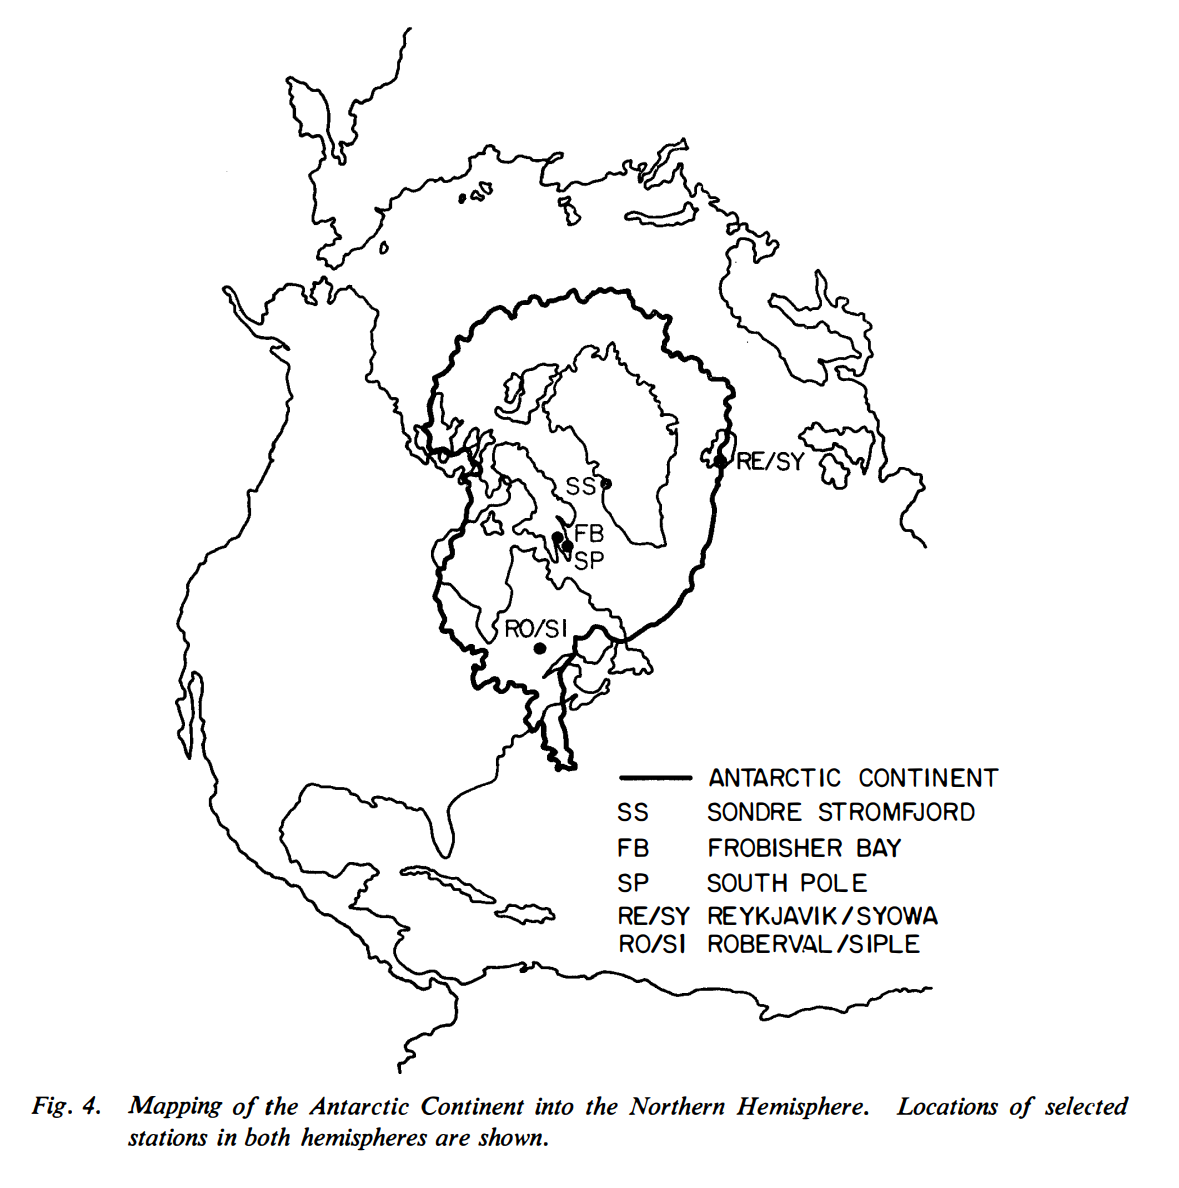

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import json
import ogr
import geopandas as gpd

import aacgmv2
import datetime as dt
import numpy as np


import pandas as pd
smag = __import__('supermag-api')          # SuperMAG python API
logon = 'kd8oxt'                              # SuperMAG ID

# # For pulling data from CDAweb:
# from ai import cdas
# import datetime
# from matplotlib import pyplot as plt

import gpxpy
import gpxpy.gpx

import geopandas

Here's a function to take in a dataframe and add columns for all stages of calculating conjugate points:

In [ ]:
def conjcalc(gdf, latname="GLAT", lonname="GLON", dtime = dt.datetime(2013, 11, 3)):
    # Prallocate columns for magnetic coordinates:
    gdf['MLAT'] = np.nan
    gdf['MLON'] = np.nan
    gdf['MALT'] = np.nan
    gdf['CMLAT'] = np.nan # conjugate latitude, magnetic
    gdf['CMLON'] = np.nan # conjugate longitude, magnetic
    gdf['CGLAT'] = np.nan # conjugate latitude, geographic
    gdf['CGLON'] = np.nan # conjugate longitude, geographic
    gdf['CGALT'] = np.nan # conjugate longitude, geographic
    gdf['Hemisphere'] = np.nan
    gdf['PLAT'] = np.nan # latitude and longitude to plot
    gdf['PLON'] = np.nan # latitude and longitude to plot

    # Iterate over the DataFrame
    for index, row in gdf.iterrows():
        try:
            lat = float(row[latname])
            lon = float(row[lonname])
            
            # Apply the aacgmv2 function
            gdf.loc[index, 'MLAT'], gdf.loc[index, 'MLON'], gdf.loc[index, 'MALT']  =  aacgmv2.wrapper.convert_latlon(lat, lon, 300, dtime, method_code = "G2A")
            gdf.loc[index, 'CMLAT'] = -gdf.loc[index, 'MLAT']
            gdf.loc[index, 'CMLON'] = -gdf.loc[index, 'MLON']
            gdf.loc[index, 'CGLAT'], gdf.loc[index, 'CGLON'], gdf.loc[index, 'CGALT']  =  aacgmv2.wrapper.convert_latlon(gdf.loc[index, 'CMLAT'], gdf.loc[index, 'CMLON'], 300, dtime, method_code="A2G")
            
            # Figure out what coordinates we ultimately want to plot:
            if gdf.loc[index, 'CMLAT']<0:
                # print('Setting Northern hemisphere for CMLAT of ' + str(gdf.loc[index, 'CMLAT']) + ' on station ' + index)
                gdf.loc[index, 'Hemisphere'] = 'N'
                gdf.loc[index, 'PLAT'] = lat
                gdf.loc[index, 'PLON'] = lon

            else:
                # print('Setting Southern hemisphere for CMLAT of ' + str(gdf.loc[index, 'CMLAT']) + ' on station ' + index)
                gdf.loc[index, 'Hemisphere'] = 'S'
                gdf.loc[index, 'PLAT'] = gdf.loc[index, 'CGLAT']
                gdf.loc[index, 'PLON'] = gdf.loc[index, 'CGLON']
                
            
        except Exception as e:
            print('Ran into a problem with ' + str(index))
            print(e)
            continue

    return gdf

## Stations and Features
First, let's collect stations and features of interest into pandas dataframes. (Make sure to include dates of operation wherever possible - want to make sure that we have that information when creating historical maps later!)

I'm collecting station information here: https://docs.google.com/spreadsheets/d/1DYVxUyF0DDpw7SoCTTIANWcNzMouLW6NB8Slq00Icc8/edit?usp=sharing

In [ ]:
import pandas as pd
stations = pd.read_csv('https://docs.google.com/spreadsheets/d/' + 
                   '1DYVxUyF0DDpw7SoCTTIANWcNzMouLW6NB8Slq00Icc8'+
                   # '/edit#gid=0'
                   # '0Ak1ecr7i0wotdGJmTURJRnZLYlV3M2daNTRubTdwTXc' +
                   '/export?gid=0&format=csv',
                   # Set first column as rownames in data frame
                   index_col=0,
                   # Parse column values to datetime
                   parse_dates=['Start', 'End']
                  )
stations["Source"] = "Manual"
stations.head()  # Same result as @TomAugspurger

### Marc Engebretson's wish list:

- [ ] *TODO*: Get each of these into a spreadsheet/dataframe and import them to this notebook accordingly.

- [ ] Figure 1 and Table 1 in the attached file “JGRA – 2022 – Engebretson…”  show stations used in one of my recent papers.  The table contains a full list of AAL-PIP stations in Antarctica but only a partial list of stations in the other arrays mentioned.  In Figure 1 the stations in one high latitude hemisphere are mapped to their magnetically conjugate region in the other hemisphere. 
- [ ] Greenland coastal arrays:  a web site with the full list of west coast and east coast stations is
https://www.space.dtu.dk/english/research/scientific_data_and_models/magnetic_ground_stations#list  
Only one of the stations on the Greenland Ice Cap is still operating. See tables in doi.org/10.1029/2022JA030580

- [ ] British Antarctic survey chain:  Coordinates are part of the station name, as in “M85-002 – 85.36° 2.06°” in Table 1 of the attached file “JGRA – 2022 – Engebretson…”.  The full list of stations is in the attached file ”Full Record – LPM…” https://www.bas.ac.uk/project/low-power-magnetometer-lpm-network/
- [ ] AUTUMNX array coordinates are in the attached file “Connors2016…..”  doi.org/10.1186/s40623-015-0354-4 See Figure 4 (yellow circles) and Table 1.  They are also available at https://autumn.athabascau.ca/TBS_autumnxquery2.php
- [X] MACCS array coordinates are in the attached file “MACCS array and…”  (see link below)
- [ ] CANMOS array geographic coordinates are listed here:  https://geomag.nrcan.gc.ca/obs/default-en.php

### Northern Hemisphere Stations
- [ ] AMISR - should be conjugate with McMurdo
- [X] MACCS network
- [ ] North American research institutions (CWRU, MIT, NJIT, VA Tech, DTU, and other universities who have space wx/have expressed interest)
- [ ] ISRs
- [ ] All-sky cameras
- [X] Full set of magnetometer networks from SuperMAG

Let's pull some more Northern hemisphere stations from the list of instruments in the Madrigal database, at http://cedar.openmadrigal.org/instMetadata. (It would be good form to use the `madrigalWeb` python package for this if we need more data.)

In [ ]:
# madrigal = pd.read_csv("madrigal.csv")
madrigal = pd.read_html("http://cedar.openmadrigal.org/instMetadata")[0]
madrigal = madrigal.rename(columns={"3-letter mnemonic": "ID", "Latitude": "GLAT", "Longitude (-180-180)":"GLON"})
madrigal = madrigal.set_index("Name")
madrigal["Source"] = "Madrigal"

# add to stations list:
stations = pd.concat([stations, madrigal], ignore_index=False)

Downloading SUPERMAG's list of stations from https://supermag.jhuapl.edu/mag/?fidelity=low&tab=stationinfo&start=2001-01-01T00%3A00%3A00.000Z&interval=23%3A59#:

(I've edited the operators column of the spreadsheet to make it digestible to pandas...)

In [ ]:
supermag = pd.read_csv("20230803-11-15-supermag-stations.csv", sep = ',') 

supermag = supermag.rename(columns={"STATION-NAME":"Name", "IAGA": "ID", "GEOLAT": "GLAT", "GEOLON":"GLON", "OP1":"Network"})
supermag = supermag.set_index("Name")
supermag["Category"] = "Magnetometers"
supermag["Source"] = "SuperMAG"

# add to stations list:
stations = pd.concat([stations, supermag], ignore_index=False)

stations

Alternatively, we can pull data using the SuperMAG API:

### Antarctic Stations
- [x] AALPIP stations
- [x] Import COMNAP data - use https://github.com/PolarGeospatialCenter/comnap-antarctic-facilities/tree/master

In [ ]:
url = "https://github.com/PolarGeospatialCenter/comnap-antarctic-facilities/raw/master/dist/COMNAP_Antarctic_Facilities_Master.xls"

comnap_df = pd.read_excel(url)

comnap = comnap_df.rename(columns={"English Name":"Name", "Type": "Category", "Latitude (DD)": "GLAT", "Longitude (DD)":"GLON", "Operator (primary)":"Nation"})
comnap = comnap.set_index("Name")
comnap["Source"] = "COMNAP"

# add to stations list:
stations = pd.concat([stations, comnap], ignore_index=False)

# stations

In [ ]:
import plotly.express as px
fig = px.scatter_geo(comnap_df,
                    lat=comnap_df["Latitude (DD)"],
                    lon=comnap_df["Longitude (DD)"],
                    hover_name="English Name",
                    color = "Type")
fig.update_geos(projection_type="orthographic")
fig.show()

### Eclipse Paths
- [ ] June 2020 Eclipse 
- [ ] December 2020 Eclipse 

Shunrong Zhang computed paths at various elevations for the 2017 eclipse. Those can be found here: http://aeronomy.haystack.mit.edu/share/eclipse_2017/

In [ ]:
url = 'http://aeronomy.haystack.mit.edu/share/eclipse_2017/eclipse20170821.txt.000km.hiRes'
header = ["YEAR/M/DD", "HH:MM:SS",  "UTC", "MIN Magni", "LAT", "LONG"]
#Min Magni = minimum obscuration magnitude (ratio), based on the fraction of the visible solar disk area screened by the Moon
eclipse = pd.read_csv(url, sep='\s+', names = header)
eclipse

In [ ]:
# import pandas as pd
# import numpy as np

df = eclipse[['LAT', 'LONG']]

# print(df)

# import gpxpy
# import gpxpy.gpx

gpx = gpxpy.gpx.GPX()

# Create first track in our GPX:
gpx_track = gpxpy.gpx.GPXTrack()
gpx.tracks.append(gpx_track)

# Create first segment in our GPX track:
gpx_segment = gpxpy.gpx.GPXTrackSegment()
gpx_track.segments.append(gpx_segment)

# Create points:
for idx in df.index:
    gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(df.loc[idx, 'LAT'], df.loc[idx, 'LONG']))

# print(gpx.to_xml())

with open('output/eclipse.gpx', 'w') as f:
    f.write(gpx.to_xml())

### Satellite Paths
- [ ] GOES East

## Maps

### Global Map
- [x] Let's begin by plotting all the points on a globe map using plotly express.

In [ ]:
fig = px.scatter_geo(stations.reset_index(),
                    lat=stations["GLAT"],
                    lon=stations["GLON"],
                    hover_name="Name",
                    hover_data=["Category"],
                    color = "Category")
fig.update_geos(projection_type="orthographic")
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules

fig.show()
fig.write_html("all-stations.html")

### Antarctic Coastline
- [X] Pull data from https://geodata.lib.berkeley.edu/catalog/stanford-yk702xd7587
- [ ] Map the data with plotly express or similar
- [ ] Convert the coordinates to geomagnetic coordinates and plot them

In [ ]:
gdf = geopandas.read_file("stanford-yk702xd7587-geojson.json")
gdf.geometry

# df.geometry[0].exterior

points = []
for polygon in gdf.geometry[0]:
    for point in polygon.exterior.coords:
        points.append({"lat": point[1], "lon": point[0]})
Antarctic_coastline = pd.DataFrame(points)

with open('stanford-yk702xd7587-geojson.json') as f:
  Antarctic_coast = json.load(f)

We can visualize the geometry of the coastline directly in Jupyter notebook. Yep, looks like Antarctica:

In [ ]:
gdf.geometry[0]

Let's compute the conjugate points for this outline, then export them as a .gpx file. That shape is *huge*, so let's  reduce the resolution so it's easier to run computations on.

In [ ]:
# foo = conjcalc(Antarctic_coastline.sample(20000).sort_index(), latname = 'lat', lonname='lon')
foo = conjcalc(Antarctic_coastline.sample(10000).sort_values('lon'), latname = 'lat', lonname='lon')

df = foo[['PLAT', 'PLON']]

gpx = gpxpy.gpx.GPX()

# Create first track in our GPX:
gpx_track = gpxpy.gpx.GPXTrack()
gpx.tracks.append(gpx_track)

# Create first segment in our GPX track:
gpx_segment = gpxpy.gpx.GPXTrackSegment()
gpx_track.segments.append(gpx_segment)

# Create points:
for idx in df.index:
    gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(df.loc[idx, 'PLAT'], df.loc[idx, 'PLON']))

# print(gpx.to_xml())

with open('output/conj-Ant.gpx', 'w') as f:
    f.write(gpx.to_xml())


### Coordinate Conversions
- [X] Create/find a function to convert geographic to geomagnetic coordinates. Might try https://pypi.org/project/aacgmv2/ or https://github.com/space-physics/geo2mag
- [X] Add a column with the conjugate geomagnetic coordinates
- [X] Add a column with the conjugate geomagnetic coordinates converted back into geographic coordinates
- [X] Map the geographic coordinates of the Northern Hemisphere stations and the conjugate geographic coordinates of the Southern Hemisphere stations

In [ ]:
stations = conjcalc(stations)

Now to save it as a .gpx file (Run `pip install gpxpy` if you don't have it installed already) and a .CSV:

In [ ]:
stations.to_csv('output/stations.csv') #save as .csv

And map:

In [ ]:
fig = px.scatter_geo(stations.reset_index(),
                    lat=stations["PLAT"],
                    lon=stations["PLON"],
                    hover_name="Name",
                    hover_data=["Category"],
                    color = "Hemisphere")
fig.update_geos(projection_type="orthographic")
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules

fig.show()
fig.write_html("output/conj-stations.html")

In [ ]:
fig = px.scatter_geo(foo.reset_index(),
                    lat=stations["PLAT"],
                    lon=stations["PLON"],
                    hover_name="Name",
                    hover_data=["Category"],
                    color = "Hemisphere")
fig.update_geos(projection_type="orthographic")
fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules

fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules
fig.update_geos(projection_type="orthographic")
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})

fig.write_html("output/conj-stations.html")

## Graticules
- [X] Figure out how to plot graticules (lat/lon lines) for both geographic coordinates.
- [ ] Figure out how to plot graticules for magnetic coordinates.

In [ ]:
# gdf = geopandas.read_file(file_path)
gdf = gdf.explode(ignore_index=True)

fig = px.choropleth(
    gdf,
    geojson=gdf.geometry,
    # color='surface',
    # scope="north america",
    locations=gdf.index##['surface']
)

fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True) # geographic graticules
fig.update_geos(projection_type="orthographic")
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Citations
- Please cite this item as 'Gerrish, L., Ireland, L., Fretwell, P., & Cooper, P. (2023). High resolution vector polylines of the Antarctic coastline (7.7) [Data set]. UK Polar Data Centre, Natural Environment Research Council, UK Research & Innovation. https://doi.org/10.5285/70ac5759-34ee-4f39-9069-2116db592340'. If using for a graphic or if short on space, please cite as 'data from the SCAR Antarctic Digital Database, 2023'

- Shepherd, S. G. (2014), Altitude‐adjusted corrected geomagnetic coordinates: Definition and functional approximations, Journal of Geophysical Research: Space Physics, 119, 7501–7521, doi:10.1002/2014JA020264.

- Connors, M., Schofield, I., Reiter, K. et al. The AUTUMNX magnetometer meridian chain in Québec, Canada. Earth Planet Sp 68, 2 (2016). https://doi.org/10.1186/s40623-015-0354-4

- Gjerloev, J. W. (2012), The SuperMAG data processing technique, J. Geophys. Res., 117, A09213, doi:10.1029/2012JA017683.
- Gjerloev, J. W. (2009), A Global Ground-Based Magnetometer Initiative, EOS, 90, 230-231, doi:10.1029/2009EO270002.

- Acknowledgment: The authors used the Bard large language model from Google AI to generate some of the code used in this work.

- cite https://geodata.lib.berkeley.edu/catalog/stanford-yk702xd7587

### Other stuff to try....

- Animated plot, like the one in this example (https://rstudio-pubs-static.s3.amazonaws.com/600936_f56ee4248a3f4b5098e49ab7a56dc1ab.html), showing the movement of magnetic coordinates over time